In [105]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import pyaldata as pyd
import scipy
import seaborn as sns
from utils import *

# Load and process data

In [106]:
dataset = 'M033_2024_04_11_08_22'
mouse_id = 'M033'

In [107]:
data_dir = '/data/mouse_data/processed/'+mouse_id+'/'+dataset+'/'
fname = os.path.join(data_dir, dataset+'_pyaldata.mat')

In [108]:
df = pyd.mat2dataframe(fname, shift_idx_fields=False, td_name='df')

df['bin_size'] = 0.01

df = pyd.remove_low_firing_neurons(df, "m1_spikes",  1)
df = pyd.remove_low_firing_neurons(df, "s1_spikes", 1)
df = pyd.remove_low_firing_neurons(df, "str_motor_spikes",  1)
df = pyd.remove_low_firing_neurons(df, "str_sensor_spikes", 1)

df = pyd.transform_signal(df, "m1_spikes",  'sqrt')
df = pyd.transform_signal(df, "s1_spikes", 'sqrt')
df = pyd.transform_signal(df, "str_motor_spikes",  'sqrt')
df = pyd.transform_signal(df, "str_sensor_spikes", 'sqrt')

df = pyd.add_firing_rates(df,'smooth')

/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/pandas/core/series.py:1031: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


field sol_nb could not be converted to int.


/home/cf620/git/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/cf620/git/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/cf620/git/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(
/home/cf620/git/PyalData/pyaldata/firing_rates.py:108: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn(


In [109]:
from sklearn.decomposition import PCA, FactorAnalysis

pca_dims = 15

df = pyd.dim_reduce(df, PCA(pca_dims), "m1_rates", "m1_pca")
df = pyd.dim_reduce(df, PCA(pca_dims), "s1_rates", "s1_pca")
df = pyd.dim_reduce(df, PCA(pca_dims), "str_motor_rates", "str_motor_pca")
df = pyd.dim_reduce(df, PCA(pca_dims), "str_sensor_rates", "str_sensor_pca")


In [110]:
df_perturbed = df[df['trialType']=='perturbation']
df_spontaneous = df[df['trialType']=='spontaneous']

In [111]:
def get_correlation_distribution(df, signal):

    rates = pyd.concat_trials(df,signal)

    # Compute the pairwise correlation matrix
    correlation_matrix = np.corrcoef(rates.T)

    # Extract the upper triangle of the correlation matrix, excluding the diagonal
    upper_triangle_indices = np.triu_indices_from(correlation_matrix, k=1)
    upper_triangle_values = correlation_matrix[upper_triangle_indices]

    return upper_triangle_values



In [112]:
m1_dist_perturbed = get_correlation_distribution(df_perturbed,'m1_rates')
str_motor_dist_perturbed = get_correlation_distribution(df_perturbed,'str_motor_rates')
s1_dist_perturbed = get_correlation_distribution(df_perturbed,'s1_rates')
str_sensor_dist_perturbed = get_correlation_distribution(df_perturbed,'str_sensor_rates')

m1_dist_spontaneous = get_correlation_distribution(df_spontaneous,'m1_rates')
str_motor_dist_spontaneous = get_correlation_distribution(df_spontaneous,'str_motor_rates')
s1_dist_spontaneous = get_correlation_distribution(df_spontaneous,'s1_rates')
str_sensor_dist_spontaneous = get_correlation_distribution(df_spontaneous,'str_sensor_rates')

/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


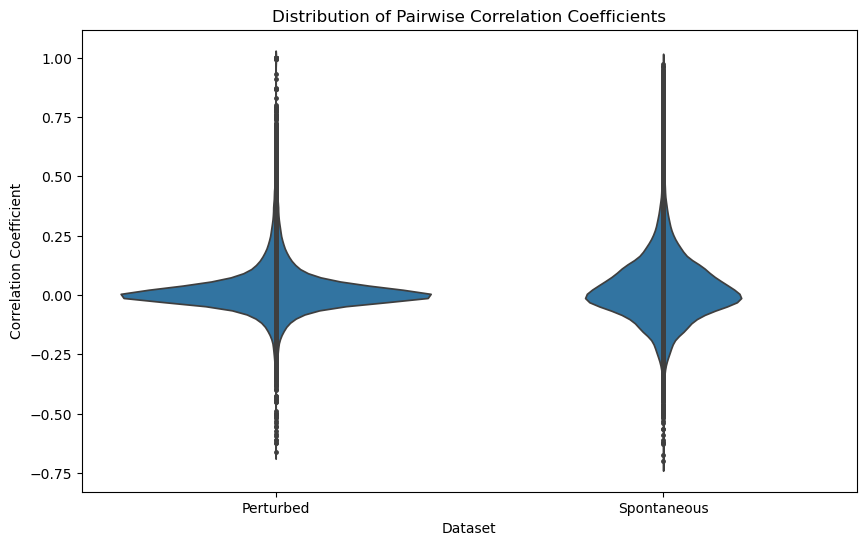

In [113]:
# Combine the data into a single DataFrame
data = pd.DataFrame({
    'Correlation': np.concatenate([str_motor_dist_perturbed, str_motor_dist_spontaneous]),
    'Dataset': ['Perturbed'] * len(str_motor_dist_perturbed) + ['Spontaneous'] * len(str_motor_dist_spontaneous)
})

# Plot the distributions using a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Dataset', y='Correlation', data=data, inner="point")
plt.title('Distribution of Pairwise Correlation Coefficients')
plt.xlabel('Dataset')
plt.ylabel('Correlation Coefficient')
plt.show()

/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/cf620/miniconda3/envs/quake/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divi

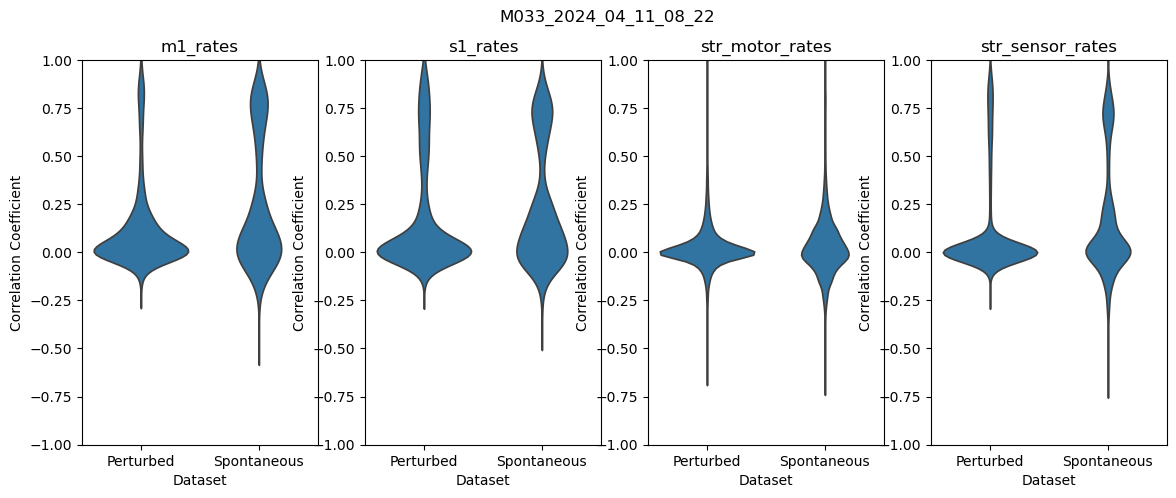

In [114]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5))

axs = axs.flatten()

list_of_regions = ['m1_rates', 's1_rates', 'str_motor_rates', 'str_sensor_rates']

for i, region in enumerate(list_of_regions):
    rates_perturbed = get_correlation_distribution(df_perturbed,region)
    rates_spontaneous = get_correlation_distribution(df_spontaneous,region)

    # Combine the data into a single DataFrame
    data = pd.DataFrame({
        'Correlation': np.concatenate([rates_perturbed, rates_spontaneous]),
        'Dataset': ['Perturbed'] * len(rates_perturbed) + ['Spontaneous'] * len(rates_spontaneous)
    })

    # Plot the distributions using a violin plot

    sns.violinplot(x='Dataset', y='Correlation', data=data, inner=None, ax=axs[i])
    axs[i].set_title(region)
    axs[i].set_xlabel('Dataset')
    axs[i].set_ylim([-1,1])
    axs[i].set_ylabel('Correlation Coefficient')

plt.suptitle(dataset)
plt.savefig('./probe_analysis/correlation/correlation_distribution_'+dataset+'.pdf')


# Correlation

(202399, 73)
(202399, 72)
(202399, 249)
(202399, 110)


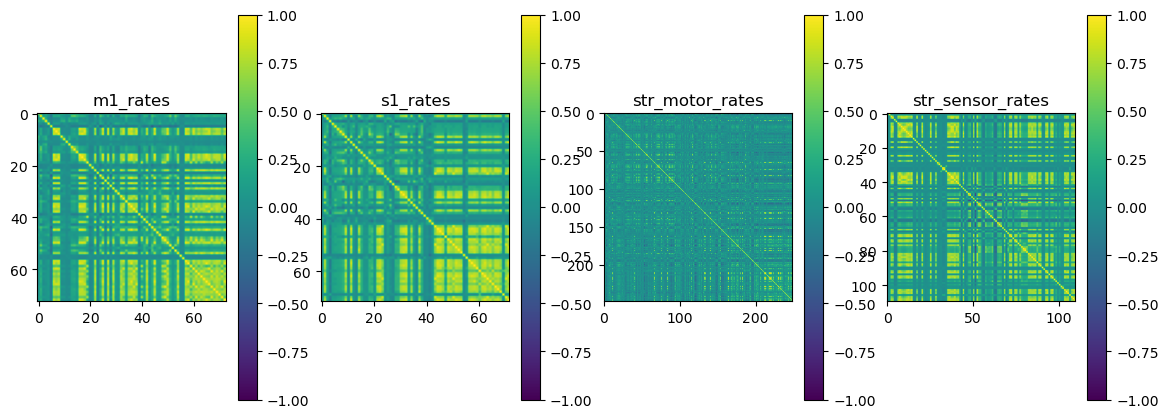

In [115]:
fig, axs = plt.subplots(1, 4, figsize=(14, 5))

axs = axs.flatten()

list_of_regions = ['m1_rates', 's1_rates', 'str_motor_rates', 'str_sensor_rates']

for i, region in enumerate(list_of_regions):

    rates = pyd.concat_trials(df, region)
    print(rates.shape)

    correlation_matrix = np.corrcoef(rates.T)

    cax = axs[i].imshow(correlation_matrix, cmap='viridis', vmin=-1, vmax=1)
    plt.colorbar(cax)
    axs[i].set_title(region)

plt.savefig('./probe_analysis/correlation/correlation_matrix_'+dataset+'.pdf')
